<a href="https://colab.research.google.com/github/prathamsss/Reinforcement_Learning/blob/main/RL_LunarLander__DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y xvfb x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 40 not upgraded.
Need to get 994 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.9 [784 kB]
Fetched 994 kB in 1s (980 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 148489 files 

In [2]:
!pip install pyvirtualdisplay==0.2.* \
             PyOpenGL==3.1.* \
             PyOpenGL-accelerate==3.1.*

     |████████████████████████████████| 538 kB 5.4 MB/s 
  Created wheel for PyOpenGL-accelerate: filename=PyOpenGL_accelerate-3.1.5-cp37-cp37m-linux_x86_64.whl size=1599536 sha256=7cf465ebc8e7a5e0f9752647464bc5ff55c52b268d9fc8f30ab032cf3202629d
  Stored in directory: /root/.cache/pip/wheels/1c/f5/6f/169afb3f2d476c5e807f8515b3c9bc9b819c3962316aa804eb
Successfully built PyOpenGL-accelerate


In [3]:
!pip install gym[box2d]==0.17.*

     |████████████████████████████████| 448 kB 5.4 MB/s 


In [4]:
%%bash
# install required system dependencies
apt-get install -y xvfb x11-utils
# install required python dependencies
pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [5]:
!echo $DISPLAY


In [6]:
# Run this only once
import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [7]:
!echo $DISPLAY # should now be set to some value


:1001


In [20]:

import typing

import gym
import matplotlib.pyplot as plt
import numpy as np
from IPython import display
import random
import sys
from time import time
from collections import deque, defaultdict, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# ​import matplotlib.pyplot as plt
from matplotlib import  pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [21]:
env = gym.make('LunarLander-v2')
env.seed(0)


[0]

In [22]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box(-inf, inf, (8,), float32)


In [23]:
# Agent that takes random actions
max_episodes = 100

In [24]:
scores = []
actions = range(env.action_space.n)
for i in range(1, max_episodes+1):
    state = env.reset()
    score = 0
    while True:
        action = np.random.choice(actions)
        state, reward, done, info = env.step(action)
        score += reward
        if done:
            if i % 20 == 0:
                print('Episode {},  score: {}'.format(i, score))
            break
    
    scores.append(score)

Episode 20,  score: -333.30901031884065
Episode 40,  score: -447.298711641483
Episode 60,  score: -155.541183276872
Episode 80,  score: -297.5613372228886
Episode 100,  score: -212.05022893055505


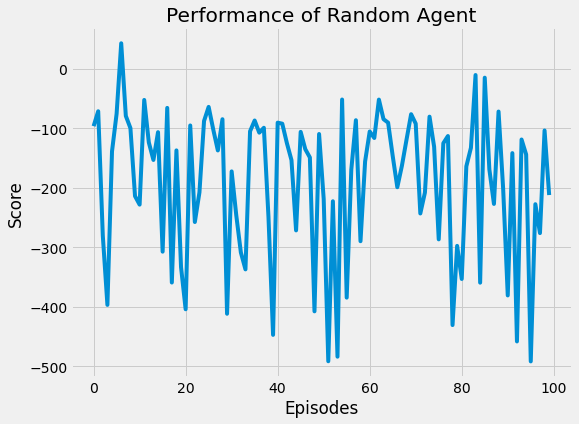

In [25]:
# Show random agent's performance
plt.figure(figsize=(8,6))
plt.plot(range(max_episodes), scores)
plt.title('Performance of Random Agent')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.show()


In [26]:
# Average score
print('Average score of random agent over {} episodes: {:.2f}'.format(max_episodes, np.mean(scores)))

Average score of random agent over 100 episodes: -188.84


In [27]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [28]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        """
        Build a fully connected neural network
        
        Parameters
        ----------
        state_size (int): State dimension
        action_size (int): Action dimension
        seed (int): random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)  
        
    def forward(self, x):
        """Forward pass"""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x        

In [29]:
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed):
        """
        Replay memory allow agent to record experiences and learn from them
        
        Parametes
        ---------
        buffer_size (int): maximum size of internal memory
        batch_size (int): sample size from experience
        seed (int): random seed
        """
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        """Add experience"""
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)
                
    def sample(self):
        """ 
        Sample randomly and return (state, action, reward, next_state, done) tuple as torch tensors 
        """
        experiences = random.sample(self.memory, k=self.batch_size)
        
        # Convert to torch tensors
        states = torch.from_numpy(np.vstack([experience.state for experience in experiences if experience is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([experience.action for experience in experiences if experience is not None])).long().to(device)        
        rewards = torch.from_numpy(np.vstack([experience.reward for experience in experiences if experience is not None])).float().to(device)        
        next_states = torch.from_numpy(np.vstack([experience.next_state for experience in experiences if experience is not None])).float().to(device)  
        # Convert done from boolean to int
        dones = torch.from_numpy(np.vstack([experience.done for experience in experiences if experience is not None]).astype(np.uint8)).float().to(device)        
        
        return (states, actions, rewards, next_states, dones)
        
    def __len__(self):
        return len(self.memory)
    

In [32]:
BUFFER_SIZE = int(1e5) # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network
​

SyntaxError: ignored

In [33]:
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        """
        DQN Agent interacts with the environment, 
        stores the experience and learns from it
        
        Parameters
        ----------
        state_size (int): Dimension of state
        action_size (int): Dimension of action
        seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        # Initialize Q and Fixed Q networks
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.fixed_network = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters())
        # Initiliase memory 
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0
        
    
    def step(self, state, action, reward, next_state, done):
        """
        Update Agent's knowledge
        
        Parameters
        ----------
        state (array_like): Current state of environment
        action (int): Action taken in current state
        reward (float): Reward received after taking action 
        next_state (array_like): Next state returned by the environment after taking action
        done (bool): whether the episode ended after taking action
        """
        self.memory.add(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                sampled_experiences = self.memory.sample()
                self.learn(sampled_experiences)
        
    def learn(self, experiences):
        """
        Learn from experience by training the q_network 
        
        Parameters
        ----------
        experiences (array_like): List of experiences sampled from agent's memory
        """
        states, actions, rewards, next_states, dones = experiences
        # Get the action with max Q value
        action_values = self.fixed_network(next_states).detach()
        # Notes
        # tensor.max(1)[0] returns the values, tensor.max(1)[1] will return indices
        # unsqueeze operation --> np.reshape
        # Here, we make it from torch.Size([64]) -> torch.Size([64, 1])
        max_action_values = action_values.max(1)[0].unsqueeze(1)
        
        # If done just use reward, else update Q_target with discounted action values
        Q_target = rewards + (GAMMA * max_action_values * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        
        # Calculate loss
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        # backward pass
        loss.backward()
        # update weights
        self.optimizer.step()
        
        # Update fixed weights
        self.update_fixed_network(self.q_network, self.fixed_network)
        
    def update_fixed_network(self, q_network, fixed_network):
        """
        Update fixed network by copying weights from Q network using TAU param
        
        Parameters
        ----------
        q_network (PyTorch model): Q network
        fixed_network (PyTorch model): Fixed target network
        """
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)
        
        
    def act(self, state, eps=0.0):
        """
        Choose the action
        
        Parameters
        ----------
        state (array_like): current state of environment
        eps (float): epsilon for epsilon-greedy action selection
        """
        rnd = random.random()
        if rnd < eps:
            return np.random.randint(self.action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            # set the network into evaluation mode 
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            # Back to training mode
            self.q_network.train()
            action = np.argmax(action_values.cpu().data.numpy())
            return action    
        
    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

In [36]:
BUFFER_SIZE = int(1e5) # Replay memory size
BATCH_SIZE = 64         # Number of experiences to sample from memory
GAMMA = 0.99            # Discount factor
TAU = 1e-3              # Soft update parameter for updating fixed q network
LR = 1e-4               # Q Network learning rate
UPDATE_EVERY = 4        # How often to update Q network

In [39]:
MAX_EPISODES = 2000  # Max number of episodes to play
MAX_STEPS = 1000     # Max steps allowed in a single episode/play
ENV_SOLVED = 200     # MAX score at which we consider environment to be solved
PRINT_EVERY = 100    # How often to print the progress

In [41]:
# Epsilon schedule
EPS_START = 1.0      # Default/starting value of eps
EPS_DECAY = 0.999    # Epsilon decay rate
EPS_MIN = 0.01       # Minimum epsilon 

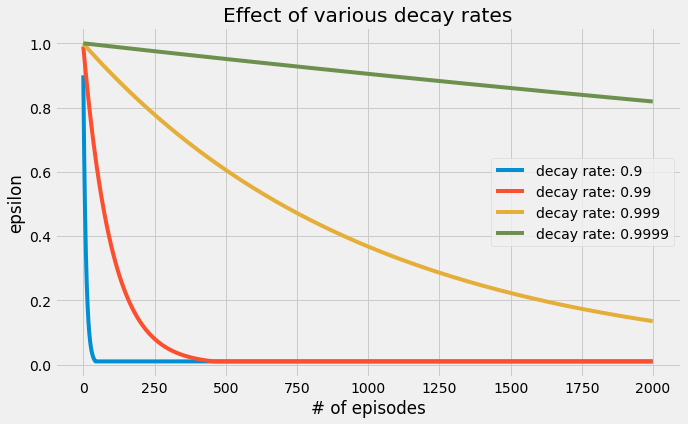

In [49]:
EPS_DECAY_RATES = [0.9, 0.99, 0.999, 0.9999]
plt.figure(figsize=(10,6))
for decay_rate in EPS_DECAY_RATES:
    test_eps = EPS_START
    eps_list = []
    for _ in range(MAX_EPISODES):
        test_eps = max(test_eps * decay_rate, EPS_MIN)
        eps_list.append(test_eps)          
    
    plt.plot(eps_list, label='decay rate: {}'.format(decay_rate))


plt.title("Effect of various decay rates")
plt.legend(loc='best')
plt.xlabel('# of episodes')
plt.ylabel('epsilon')
plt.show()

In [52]:
# Get state and action sizes
state_size = env.observation_space.shape[0]
action_size = env.action_space.n


In [53]:
print('State size: {}, action size: {}'.format(state_size, action_size))

State size: 8, action size: 4


In [54]:
dqn_agent = DQNAgent(state_size, action_size, seed=0)


In [55]:
start = time()
scores = []
# Maintain a list of last 100 scores
scores_window = deque(maxlen=100)
eps = EPS_START
for episode in range(1, MAX_EPISODES + 1):
    state = env.reset()
    score = 0
    for t in range(MAX_STEPS):
        action = dqn_agent.act(state, eps)
        next_state, reward, done, info = env.step(action)
        dqn_agent.step(state, action, reward, next_state, done)
        state = next_state        
        score += reward        
        if done:
            break
            
        eps = max(eps * EPS_DECAY, EPS_MIN)
        if episode % PRINT_EVERY == 0:
            mean_score = np.mean(scores_window)
            print('\r Progress {}/{}, average score:{:.2f}'.format(episode, MAX_EPISODES, mean_score), end="")
        if score >= ENV_SOLVED:
            mean_score = np.mean(scores_window)
            print('\rEnvironment solved in {} episodes, average score: {:.2f}'.format(episode, mean_score), end="")
            sys.stdout.flush()
            dqn_agent.checkpoint('solved_200.pth')
            break
            
    scores_window.append(score)
    scores.append(score)
    
end = time()    
print('Took {} seconds'.format(end - start))

 Progress 2000/2000, average score:230.58Took 2948.3898797035217 seconds


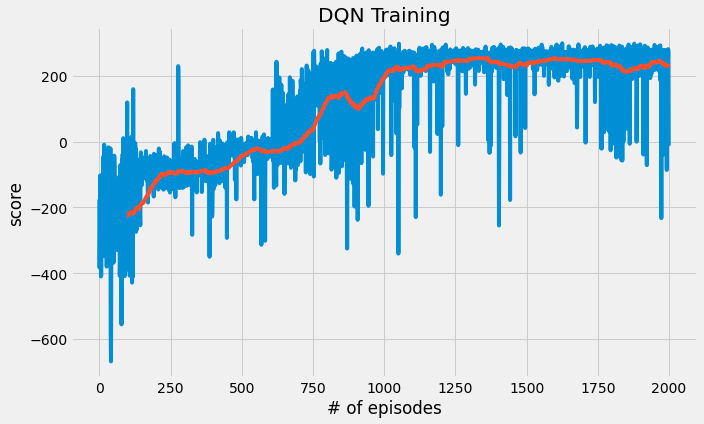

In [56]:
plt.figure(figsize=(10,6))
plt.plot(scores)
# A bit hard to see the above plot, so lets smooth it (red)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN Training')
plt.xlabel('# of episodes')
plt.ylabel('score')
plt.show()

In [57]:
dqn_agent.q_network.load_state_dict(torch.load('solved_200.pth'))

<All keys matched successfully>

In [58]:
for i in range(5):
    score = 0
    state = env.reset()
    while True:
        action = dqn_agent.act(state)
        next_state, reward, done, info = env.step(action)
        state = next_state        
        score += reward        
        if done:
            break
    print('episode: {} scored {}'.format(i, score))

episode: 0 scored 280.20832941508365
episode: 1 scored 288.5641179507106
episode: 2 scored 252.1354469509136
episode: 3 scored 249.2035754979111
episode: 4 scored 257.80816169042726


In [59]:
env.close()
